#Load in Files

### Imports

In [1]:
spark.version

u'2.2.0'

In [2]:
import re
import datetime
from pyspark.sql.functions import *
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 35)

import numpy as np
import seaborn as sns
sns.set_palette("deep", desat=0.6)
sns.set_context(rc={"figure.figsize": (8,4)})

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

### Load In NBA Score Data Set

In [24]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType,DateType

cleaned_dir = '/data2/nba-rt-prediction/sparkfiles/cleanedDF'
df = spark.read.format('csv')\
                    .option("header", "true")\
                    .option("inferSchema", "true")\
                    .option("dateFormat", "yyyy-MM-dd")\
                    .load(cleaned_dir).coalesce(2)

# For some reason my key is none upon load ! Rebuild
df = df.withColumn("key", concat(col("dateStr"),lit("."),col("away_team"),lit("."),col("home_team")))
               
# Here use Pandas Dataframes as visualization needs to run in the driver
# downsample if necessary
visdf = df.toPandas()
visdf[0:9]

,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,score_diff_amh,date,time_elapsed,pct_complete,pct_left,cf1,away_team_spread,overunder,away_team_ml,home_team_ml,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,final_away_score,final_home_score,away_win,dfa,outlier,key
0,2016-04-22,23:59:38,San Antonio,95.772358,Memphis,86.804878,(0:56 IN 4TH),1.0,san,mem,8.967480,2016-04-22,47.0,97.916667,2.083333,0.936609,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,-3.389736,0,2016-04-22 00:00:00.san.mem
1,2016-04-22,23:59:38,San Antonio,94.065041,Memphis,85.341463,(0:56 IN 4TH),1.5,san,mem,8.723577,2016-04-22,46.5,96.875000,3.125000,0.555178,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,-2.125254,0,2016-04-22 00:00:00.san.mem
2,2016-04-22,23:59:38,San Antonio,92.357724,Memphis,83.878049,(0:56 IN 4TH),2.0,san,mem,8.479675,2016-04-22,46.0,95.833333,4.166667,0.382746,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,-0.860772,0,2016-04-22 00:00:00.san.mem
3,2016-04-22,23:59:38,San Antonio,90.650407,Memphis,82.414634,(0:56 IN 4TH),2.5,san,mem,8.235772,2016-04-22,45.5,94.791667,5.208333,0.286726,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,0.403709,0,2016-04-22 00:00:00.san.mem
4,2016-04-22,23:52:06,San Antonio,88.888889,Memphis,81.000000,(2:59 IN 4TH),3.0,san,mem,7.888889,2016-04-22,45.0,93.750000,6.250000,0.226408,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,1.673611,0,2016-04-22 00:00:00.san.mem
5,2016-04-22,23:51:05,San Antonio,87.000000,Memphis,81.000000,(3:08 IN 4TH),3.5,san,mem,6.000000,2016-04-22,44.5,92.708333,7.291667,0.185403,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,1.656250,0,2016-04-22 00:00:00.san.mem
6,2016-04-22,23:49:34,San Antonio,83.000000,Memphis,81.000000,(3:41 IN 4TH),4.0,san,mem,2.000000,2016-04-22,44.0,91.666667,8.333333,0.155927,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,3.750000,0,2016-04-22 00:00:00.san.mem
7,2016-04-22,23:48:03,San Antonio,83.000000,Memphis,80.473684,(4:20 IN 4TH),4.5,san,mem,2.526316,2016-04-22,43.5,90.625000,9.375000,0.133836,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,2.370066,0,2016-04-22 00:00:00.san.mem
8,2016-04-22,23:47:33,San Antonio,83.000000,Memphis,78.923077,(4:58 IN 4TH),5.0,san,mem,4.076923,2016-04-22,43.0,89.583333,10.416667,0.116737,-11.666667,181.5,-553.333333,338.333333,2016-04-22,96.583333,84.916667,96,87,1,2.014423,0,2016-04-22 00:00:00.san.mem


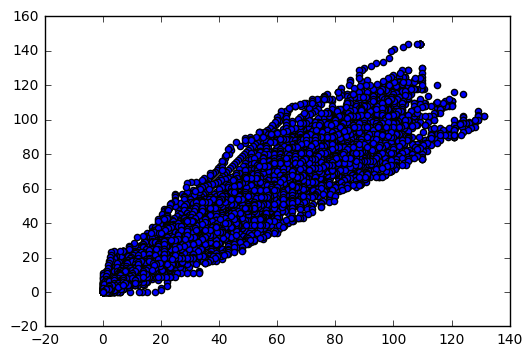

In [10]:
### Show the average number of points per game in a histogram
#visdf.describe()

plt.scatter(visdf["away_score"].values,visdf["home_score"].values)
plt.show()
#plt.scatter(visdf["away_score"].values,visdf["time_elapsed"].values)
#plt.show()

### Histograms 

(array([ 12.,   2.,   0.,   0.,   2.,   3.,   1.,  78.,  21.,   5.]),
 array([  48. ,   54.2,   60.4,   66.6,   72.8,   79. ,   85.2,   91.4,
          97.6,  103.8,  110. ]),
 <a list of 10 Patch objects>)

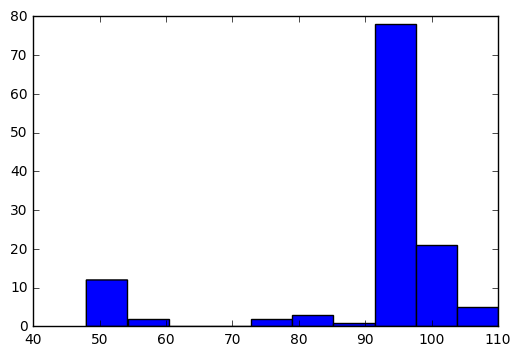

In [11]:
a = visdf.groupby("key").agg(['count']).ts
plt.hist(a.values)

In [ ]:


margin of victory



<<<<<<<<, spread >>>>>>>>>>>>>>>

In [25]:
#a = visdf.groupby("key").sum()
#a
#df = df.select(["key", "final_away_score"]).distinct()

df1 = df.withColumn("blah", col("dateStr").cast('string'))

#.cast('string')
#s("key", concat(col("dateStr"),lit("."),col("away_team"),lit("."),col("home_team")))
df1.show()                           

+-------------------+--------+--------------+-----------------+--------------+-----------------+-------------+--------+---------+---------+--------------------+-------------------+------------+-----------------+------------------+--------------------+-------------------+---------+------------------+-----------------+-------------------+----------------------+----------------------+----------------+----------------+--------+--------------------+-------+--------------------+-------------------+
|           dateOrig|      ts|away_team_full|       away_score|home_team_full|       home_score|   timestring|timeleft|away_team|home_team|      score_diff_amh|               date|time_elapsed|     pct_complete|          pct_left|                 cf1|   away_team_spread|overunder|      away_team_ml|     home_team_ml|            dateStr|away_team_vegas_fscore|home_team_vegas_fscore|final_away_score|final_home_score|away_win|                 dfa|outlier|                 key|               blah|
+---

In [ ]:


plt.scatter(a.values)


final_home_score - final_away_score

(array([  289.,    97.,   651.,  1135.,  1475.,  2915.,  1901.,  1800.,
          765.,   342.]),
 array([  84.91666667,   88.3375    ,   91.75833333,   95.17916667,
          98.6       ,  102.02083333,  105.44166667,  108.8625    ,
         112.28333333,  115.70416667,  119.125     ]),
 <a list of 10 Patch objects>)

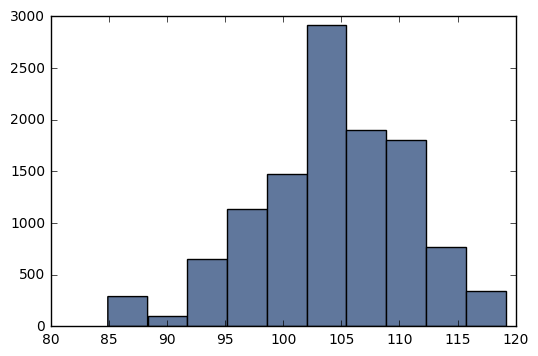

In [27]:
### Tutorial
plt.hist(visdf.home_team_vegas_fscore)

(array([  544.,   952.,  1403.,  1000.,   853.,  2381.,  1312.,  1220.,
         1369.,   336.]),
 array([-13. ,  -9.8,  -6.6,  -3.4,  -0.2,   3. ,   6.2,   9.4,  12.6,
         15.8,  19. ]),
 <a list of 10 Patch objects>)

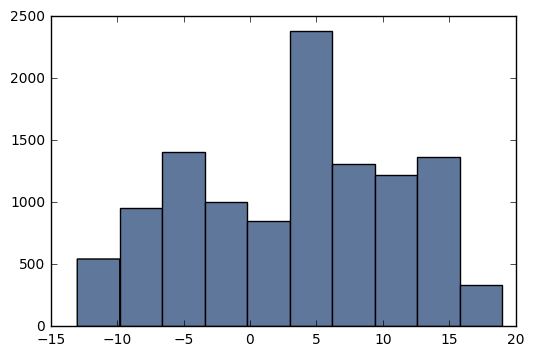

In [28]:
plt.hist(visdf.away_team_spread)

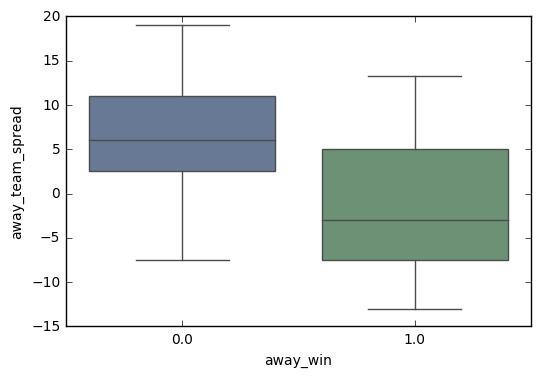

In [31]:
sns.boxplot(visdf.away_win, visdf.away_team_spread)

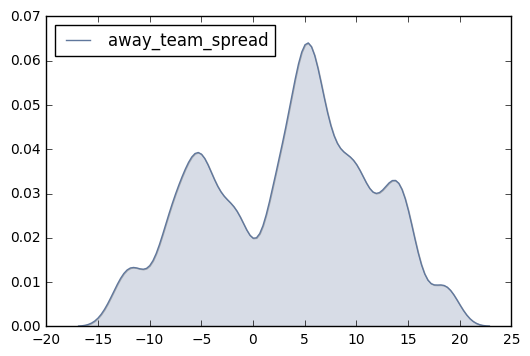

In [34]:
sns.kdeplot(visdf.away_team_spread, shade=True)

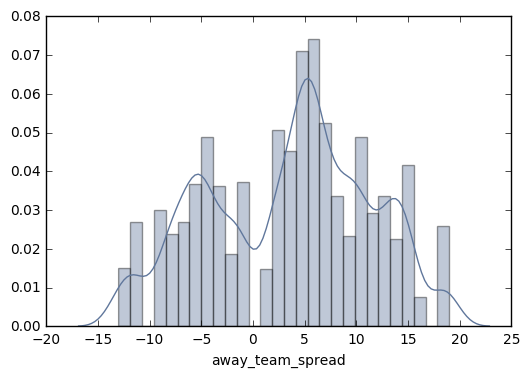

In [36]:
sns.distplot(visdf.away_team_spread)

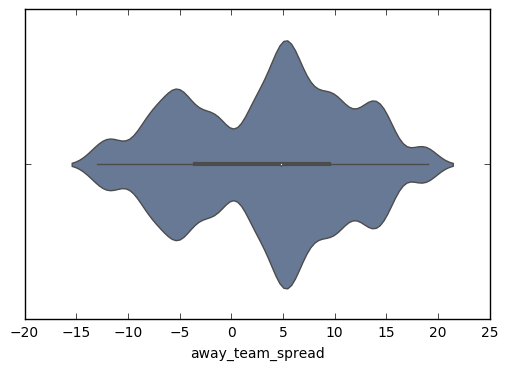

In [37]:
sns.violinplot(visdf.away_team_spread)

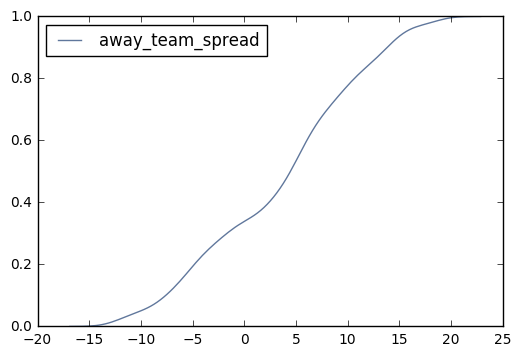

In [38]:
sns.kdeplot(visdf.away_team_spread, cumulative=True)